This script generates hillslope mesh with a varying organic layer thickness at the top.

In [1]:
import sys,os
sys.path.append(os.path.join(os.environ['ATS_SRC_DIR'],'tools','meshing_ats'))
import meshing_ats

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

# of x and z elements: 101, 101
# of cells: 100


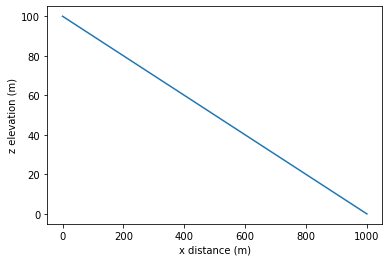

In [2]:
# 1 km long hillslope, 10% slope
x = np.linspace(0,1000,101)
z = 100 - 0.1*x
print(f'# of x and z elements: {len(x)}, {len(z)}')
plt.plot(x,z); plt.xlabel('x distance (m)'); plt.ylabel('z elevation (m)')
m2 = meshing_ats.Mesh2D.from_Transect(x,z)
print(f'# of cells: {m2.num_cells()}')

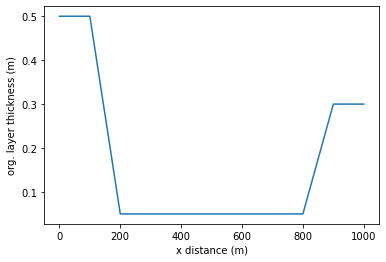

In [3]:
# Changing organic layer thickness 
def organic_thickness(x):
    """This function is the thickness of the layer we want to vary"""
    if x < 100:
        thickness = 0.5
    elif ((100 <= x) and (x <= 200)):
        thickness = -0.0045*x + 0.95
    elif ((200 < x) and (x < 800)):
        thickness = 0.05
    elif ((800 <= x) and (x <= 900)):
        thickness = 0.0025*x - 1.95
    else:
        thickness = 0.3
    return thickness

org_layer_thickness = np.array([organic_thickness(xx) for xx in m2.coords[:,0]])
plt.plot(x, org_layer_thickness[0:101]); plt.xlabel('x distance (m)'); plt.ylabel('org. layer thickness (m)');


In [4]:
# preparing layer extrusion data for meshing_ats
#
# Meshes are extruded in the vertical by "layer", where a layer may 
# consist of multiple cells in the z direction.  These layers are 
# logical unit to make construction easier, and may or may not 
# correspond to material type (organic/mineral soil).
# 
# The extrusion process is then given four lists, each of length
# num_layers.
#
layer_types = []  # a list of strings that tell the extruding 
                  # code how to do the layers.  See meshing_ats 
                  # documentation for more, but here we will use
                  # only "constant", which means that dz within
                  # the layer is constant.

layer_data = []   # this data depends upon the layer type, but
                  # for constant is the thickness of the layer

layer_ncells = [] # number of cells (in the vertical) in the layer.
                  # The dz of each cell is the layer thickness / number of cells.

layer_mat_ids = []# The material ID.  This may be either a constant int (for
                  # unform layering) or an array of size [ncells_vertical x ncells_horizontal] in the layer 
                  # where each entry corresponds to the material ID of that cell.

layer_depth = []  # used later to get the mat ids right, just for bookkeeping
        
# here we will only use 1 cell per layer, so layer thickness = dz.
# We will also telescope the mesh, starting at 1cm grid cell and growing it larger in each layer.
dz = .01
i = 0
current_depth = 0
while dz < 2:
    if i<=20:            #organic
        dz *= 1.2
    elif (20<i)&(i<=26): #mineral
        dz *= 1.4
    else:                #bedrock
        dz *= 1.5
    layer_types.append("constant")
    layer_data.append(dz)
    layer_ncells.append(1)
    current_depth += dz
    layer_depth.append(current_depth)
    i += 1
    
# now add in a bunch of cells to reach 45 m, of equal dz that is ~2m.
num_of_layers=len(layer_data)
layer_types.append('constant')
layer_data.append(45 - sum(layer_data))  # note sum(layer_data) == the total mesh thickness at this point
layer_ncells.append(int(np.floor(layer_data[-1]/dz)))
layer_depth.append(45)


In [5]:
# allocate 2D matrix with cols=#cells, rows=21
mat_ids=np.zeros((m2.num_cells(), 21), 'i')
for i in range(m2.num_cells()):
    for j in range(21): # after layer 20 everything is bedrock
        if (layer_depth[j] < org_layer_thickness[i]):
            mat_ids[i,j]=1001
        else:
            mat_ids[i,j]=1002
            
# filling out layer_mat_ids
layer_mat_ids = []
for j in range(21):
    layer_mat_ids.append(mat_ids[:,j])
for j in range(21,sum(layer_ncells)):
    layer_mat_ids.append(101*np.ones((100,),'i'))

print(f'# of rows, # of cells:{np.shape(layer_mat_ids)}')

# of rows, # of cells:(40, 100)


In [7]:
# make the mesh, save it as an exodus file
m3 = meshing_ats.Mesh3D.extruded_Mesh2D(m2, layer_types,layer_data, layer_ncells, layer_mat_ids)
if os.path.exists('test_organic_highres.exo'):
    os.remove('test_organic_highres.exo')
m3.write_exodus("test_organic_highres.exo")

Opening exodus file: test_organic_highres.exo
Closing exodus file: test_organic_highres.exo


In [9]:
# Make a column that is the same as the deepest organic layer thickness for use in spinup.
# 1 km long hillslope, 10% slope
xc = np.array([0,1])
zc = np.array([0,0])
m2c = meshing_ats.Mesh2D.from_Transect(xc,zc)
print(f'# of cells: {m2c.num_cells()}')

# of cells: 1


In [11]:
column_mat_ids = [lmi[50] for lmi in layer_mat_ids]
print(column_mat_ids)

[1001, 1001, 1001, 1002, 1002, 1002, 1002, 1002, 1002, 1002, 1002, 1002, 1002, 1002, 1002, 1002, 1002, 1002, 1002, 1002, 1002, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101]


In [12]:
m3c = meshing_ats.Mesh3D.extruded_Mesh2D(m2c, layer_types,layer_data, layer_ncells, column_mat_ids)
if os.path.exists('test_organic_highres_column.exo'):
    os.remove('test_organic_highres_column.exo')
m3c.write_exodus("test_organic_highres_column.exo")

Opening exodus file: test_organic_highres_column.exo
Closing exodus file: test_organic_highres_column.exo
